# K means 

In [1]:
import numpy as np
import time

def kmeans(k, data):

    # initialize, randomly pick k instances as center
    np.random.seed(int(time.time()))
    
    # get k differnect centers
    while True:
        random_index = np.random.randint(data.shape[0], size=k)
        centers = data[random_index, :]
        if np.unique(centers, axis=0).shape[0] == k:
            break
    
    distance_table = np.zeros((centers.shape[0], data.shape[0]))
    
    # iterate untill stop changing or max iteration
    itermax = 1000
    changed = True
    iter = 0
    while changed and iter < itermax:
        
        # Show for debug
        # print(f"iter : {iter}")
        # print(f"centers : \n{centers}")

        for idx, center in enumerate(centers):
            distance = data - center
            distance_table[idx, :] = np.linalg.norm(distance, 2, axis=1)
        

        clusters = np.argmin(distance_table, axis=0)
        
        new_centers = np.zeros((k, centers.shape[1]))
        for idx in range(k):
            instances = data[clusters == idx]
            new_centers[idx, :] = np.mean(instances, axis=0)

        if np.array_equal(centers, new_centers):
            changed = False
        else:
            centers = new_centers
            iter += 1

    return centers



In [2]:
import copy

def visualize(image, centers):
    new_image = copy.deepcopy(image)
    for row in range(new_image.shape[0]):
        for col in range(new_image.shape[1]):
            
            distances = np.linalg.norm(new_image[row, col, :] - centers, 2, axis=1)
            min_index = np.argmin(distances)
            new_image[row, col, :] = centers[min_index]
            
    return new_image

# Show original image

(1024, 1024, 3)


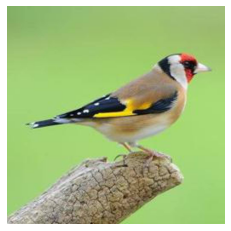

In [3]:
import cv2
import matplotlib.pyplot as plt

image = cv2.imread("bird.jpg")
print(image.shape)
# Show for debug
plt.axis("off")
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.show()

# Get ( R, G, B ) data

In [4]:
data = np.zeros((image.shape[0] * image.shape[1], 3))
i = 0

# reshape image
for row in image:
    for pixel in row:
        data[i] = pixel
        i += 1
        
np.set_printoptions(precision=4)

# ( R, G, B )

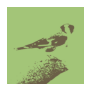

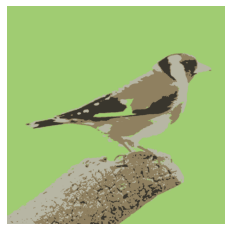

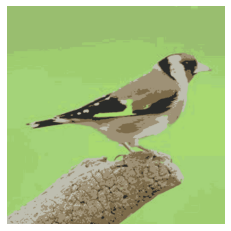

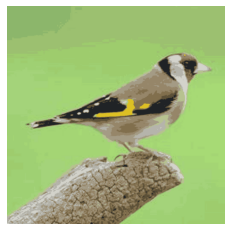

In [ ]:
num_clusters = [2, 4, 8, 16, 32]

fig = plt.figure(figsize=(8, 8))
for index, cluster in enumerate(num_clusters):
    centers = kmeans(cluster, data)
    new_image = visualize(image, centers)
    
    # Show for debug
    fig.add_subplot(1, len(num_clusters), index + 1)
    plt.axis("off")
    plt.imshow(cv2.cvtColor(new_image, cv2.COLOR_BGR2RGB))
    plt.show()

    cv2.imwrite(f"results/kmeans_rgb_{cluster}.png", new_image)

# Get ( R, G, B, X, Y ) data

In [ ]:
data = np.zeros((image.shape[0] * image.shape[1], 5))
i = 0

for row in range(image.shape[0]):
    for col in range(image.shape[1]):
        data[i] = np.concatenate((image[row, col, :], np.array([row, col])))
        i += 1

np.set_printoptions(precision=4)

In [ ]:
import copy

def visualize(image, centers):
    new_image = copy.deepcopy(image)
    for row in range(new_image.shape[0]):
        for col in range(new_image.shape[1]):
            coordinate = np.concatenate((new_image[row, col, :], [row, col]))
            distances = np.linalg.norm(coordinate - centers, 2, axis=1)
            min_index = np.argmin(distances)
            new_image[row, col, :] = centers[min_index][:3]
            
    return new_image

# ( R, G, B, X, Y )

In [ ]:
num_clusters = [2, 4, 8, 16, 32]

fig = plt.figure(figsize=(8, 8))
for index, cluster in enumerate(num_clusters):
    centers = kmeans(cluster, data)
    new_image = visualize(image, centers)
    
    # Show for debug
    fig.add_subplot(1, len(num_clusters), index + 1)
    plt.axis("off")
    plt.imshow(cv2.cvtColor(new_image, cv2.COLOR_BGR2RGB))
    plt.show()
    cv2.imwrite(f"results/kmeans_rgbxy_{cluster}.png", new_image)

# Improve : Normalize

In [ ]:
data = np.zeros((image.shape[0] * image.shape[1], 5))
i = 0

def normalize(image):
    new_image = np.zeros(image.shape)
    for i in range(3):
        new_image[:, :, i] = (image[:, :, i] - np.min(image[:, :, i])) / (np.max(image[:, :, i]) - np.min(image[:, :, i]))
    return new_image
        
new_image = normalize(image)
for row in range(image.shape[0]):
    for col in range(image.shape[1]):
        data[i] = np.concatenate((image[row, col, :], np.array([row/1023.0, col/1023.0])))
        i += 1

np.set_printoptions(precision=4)

In [ ]:
num_clusters = [2, 4, 8, 16, 32]

for cluster in num_clusters:
    centers = kmeans(cluster, data)
    new_image = visualize(image, centers)

    plt.axis("off")
    plt.imshow(cv2.cvtColor(new_image, cv2.COLOR_BGR2RGB))
    plt.show()

    cv2.imwrite(f"results/kmeans_rgbxy_normalize_{cluster}.png", new_image)

# Find first four eigenfaces and meanface

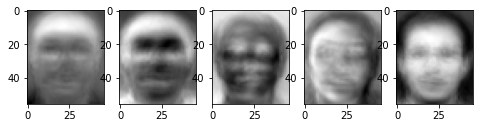

In [6]:
import cv2
import os
import numpy as np
import copy
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

def normalize(image):
    
    max_value = np.max(image)
    min_value = np.min(image)
    return 255 * ((image - min_value) / (max_value - min_value))

image_folder = "p2_data"
num_features = 56 * 46

data = np.zeros((10*40, num_features), dtype=np.uint8)
labels = np.zeros(10*40, dtype=np.uint8)

training_data = np.zeros((9*40, num_features), dtype=np.uint8)
training_labels = np.zeros(9*40, dtype=np.uint8)

testing_data = np.zeros((1*40, num_features), dtype=np.uint8)
testing_labels = np.zeros(1*40, dtype=np.uint8)

# Get training and testing data
filenames = sorted(os.listdir(image_folder), key=lambda filename:(int(filename.split("_")[0]), int(filename.split("_")[1].split(".")[0])))
for index, filename in enumerate(filenames):
    data[index, :] = cv2.imread(os.path.join(image_folder, filename), cv2.IMREAD_GRAYSCALE).flatten()
    labels[index] = int(filename.split("_")[0])
    i = int(filename.split("_")[0])
    j = int(filename.split("_")[1].split(".")[0])
    
    if j == 10:
        testing_data[i-1, :] =  data[index, :]
        testing_labels[i-1]  =  labels[index]
    else:
        training_data[(i-1)*9 + (j-1), :] = data[index, :]
        training_labels[(i-1)*9 + (j-1)]  = labels[index]

# Performing PCA
pca_features = 4
pca = PCA(n_components=pca_features, svd_solver="full")
pca.fit(training_data)
eigenfaces = np.zeros((pca_features, 56, 46))
for i in range(pca_features):
    eigenfaces[i, :, :] = pca.components_[i].reshape((56, 46))


# Show result
fig = plt.figure(figsize=(8, 8))
for i in range(pca_features):
    fig.add_subplot(1, pca_features+1, i+1)
    plt.imshow(normalize(eigenfaces[i, :, :]), cmap='gray', vmin=0, vmax=255)
    # plt.imshow(eigenfaces[i-1, :, :], cmap='gray', vmin=0, vmax=255)
    cv2.imwrite(f"results/eigenface_{i+1}.png", normalize(eigenfaces[i, :, :]))

mean_face = np.mean(testing_data, axis=0).reshape((56, 46))
fig.add_subplot(1, pca_features+1, 5)
plt.imshow(normalize(mean_face), cmap='gray', vmin=0, vmax=255)
cv2.imwrite(f"results/meanface.png", normalize(mean_face))

plt.show()


# Reconstructed and get mean square error

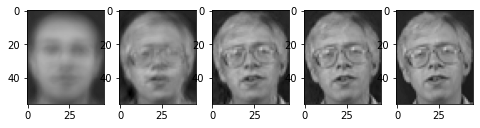

MSE : [7.46799408e+02 2.36554309e+02 4.67170497e+01 1.33666113e+01
 2.15433971e-01]


In [34]:
i = 2 # ith person
j = 1 # jth image
index = [3, 50, 170, 240, 345]
image = data[(i-1)*10 + (j-1), :][:]
mse = np.zeros(len(index))

fig = plt.figure(figsize=(8, 8))
for i in range(len(index)):
    pca = PCA(n_components=index[i], svd_solver="full")
    pca.fit(training_data)
    image_pca = pca.transform([image])

    # Show result
    fig.add_subplot(1, len(index), i+1)
    reconstructed = pca.inverse_transform(image_pca)
    mse[i] = np.mean(np.square(reconstructed - image))
    plt.imshow(reconstructed.reshape((56, 46)), cmap='gray', vmin=0, vmax=255)
    cv2.imwrite(f"results/pca_{index[i]}_reconstruct.png", reconstructed.reshape((56, 46)))
plt.show()
print(f"MSE : {mse}")

# KFold and cross validation

In [ ]:

from sklearn.model_selection import KFold
from sklearn.model_selection import cross_validate
from sklearn.neighbors import KNeighborsClassifier
np.set_printoptions(precision=4)

kf = KFold(n_splits=3, shuffle=True)
K = [1, 3, 5]    # hyperparameter of k-nearest neighbors
N = [3, 50, 170] # hyperparameter of pca n_components

pca = None
knn = None
# Train
    
for n in N:
    pca = PCA(n_components = n)
    for k in K:
        knn = KNeighborsClassifier(n_neighbors=k, algorithm='ball_tree')
        scores = []
        for train_index, validation_index in kf.split(training_data):
            
            train = training_data[train_index, :]
            train_labels = training_labels[train_index]
            validation = training_data[validation_index, :]
            validation_labels = training_labels[validation_index]
            
            # Train
            pca.fit(train)
            pca_train = pca.transform(train)
            knn.fit(pca_train, train_labels)
            
            # Predict
            pca_validation = pca.transform(validation)
            scores.append(np.sum(np.equal(knn.predict(pca_validation), validation_labels)) / len(validation_labels))
        print(f"k = {k}, n = {n}, scores : {scores}, average test scores : {np.average(scores)}")


pca_test = pca.trainsform(testing_data)
accuracy = np.sum(np.equal(knn.predict(pca_test), testing_labels)) / len(testing_labels)
print("Test set accuracy : {accuracy}")

# Gaussian Filter

In [6]:
import copy

def filter2D(gray_image, kernel):

    margin_row = kernel.shape[0] // 2
    margin_col = kernel.shape[1] // 2
    filtered = np.zeros((gray_image.shape[0] - 2*margin_row, gray_image.shape[1] - 2*margin_col))

    for row in range(margin_row, gray_image.shape[0] - margin_row):
        for col in range(margin_col, gray_image.shape[1] - margin_col):
            aggregated = np.multiply(gray_image[row-margin_row:row+margin_row+1, col-margin_col:col+margin_col+1], kernel)
            filtered[row-margin_row, col-margin_col] = np.sum(aggregated)
    
    return filtered

In [7]:
import math

def getGussianKernel(size, sigma):
    gussian_kernel = np.zeros(size)
    margin_row = gussian_kernel.shape[0] // 2
    margin_col = gussian_kernel.shape[1] // 2

    for row in range(-1 * margin_row, margin_row + 1):
        for col in range(-1 * margin_col, margin_col + 1):
            exponents = (-1 * (row**2 + col**2)) / (2 * (sigma**2))
            gussian_kernel[row + margin_row, col + margin_col] =  (1/(2*math.pi*(sigma**2))) *  math.exp(exponents)
    return gussian_kernel

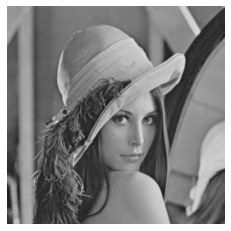

True

In [8]:

gray = cv2.imread("lena.png", cv2.IMREAD_GRAYSCALE)
sigma = 1 / ( 2 * math.log(2) )
gussian_kernel = getGussianKernel((3, 3), sigma)
filtered = filter2D(gray, gussian_kernel)

# Test case
# gray = cv2.imread("hw1/lena.png", cv2.IMREAD_GRAYSCALE)
# avg_kernel = np.ones(25, 25) / 625
# filtered = filter2D(gray, avg_kernel)

plt.axis("off")
plt.imshow(filtered, cmap='gray', vmin=0, vmax=255)
plt.show()
cv2.imwrite("results/gussianblur.png", filtered)

# Deviation

In [9]:


def conv1d(data, kernel):
    
    margin = kernel.shape[0] // 2
    conv = np.zeros(data.shape[0] - 2*margin)
    
    for i in range(margin, data.shape[0] - margin):
        aggregated = np.multiply(data[i-margin:i+margin+1], np.flip(kernel))
        conv[i-margin] = np.sum(aggregated)
    
    return conv

def normalize(gray_image):
    min_value = np.min(gray_image)
    max_value = np.max(gray_image)
    
    new_gray_image = (255 * (gray_image - min_value) / (max_value - min_value)).astype(np.int)
    return new_gray_image

kernel_x = np.array([0.5, 0, -0.5])
kernel_y = np.array([0.5, 0, -0.5]).T
margin_x = kernel_x.shape[0] // 2
margin_y = kernel_y.shape[0] // 2


Ix = np.zeros((gray.shape[0], gray.shape[1]))
Iy = np.zeros((gray.shape[0], gray.shape[1])) 

# Get Ix
for row in range(gray.shape[0]):
    Ix[row, :] = conv1d(np.pad(gray[row, :], (1, 1), 'constant', constant_values=0), kernel_x)

# Get Iy
for col in range(gray.shape[1]):
    Iy[:, col] = conv1d(np.pad(gray[:, col], (1, 1), 'constant', constant_values=0), kernel_y)

    

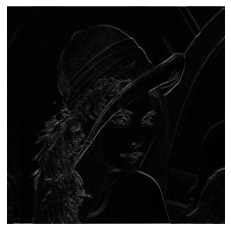

True

In [10]:
plt.axis("off")
plt.imshow(normalize(abs(Iy)), cmap='gray', vmin=0, vmax=255)
plt.show()

cv2.imwrite(f"results/normalized_abs_Iy.png", normalize(abs(Iy)))
cv2.imwrite(f"results/normalized_Iy.png", normalize(Iy))

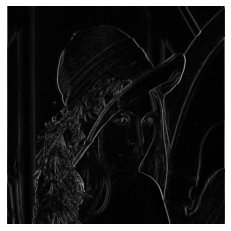

True

In [11]:
plt.axis("off")
plt.imshow(normalize(abs(Ix)), cmap='gray', vmin=0, vmax=255)
plt.show()

cv2.imwrite(f"results/normalized_abs_Ix.png", normalize(abs(Ix)))
cv2.imwrite(f"results/normalized_Ix.png", normalize(Ix))

In [26]:
def get_gradient_magnitued(gray):
    kernel_x = np.array([0.5, 0, -0.5])
    kernel_y = np.array([0.5, 0, -0.5]).T
    margin_x = kernel_x.shape[0] // 2
    margin_y = kernel_y.shape[0] // 2

    Ix = np.zeros((gray.shape[0], gray.shape[1]))
    Iy = np.zeros((gray.shape[0], gray.shape[1])) 

    # Get Ix
    for row in range(gray.shape[0]):
        Iy[row, :] = conv1d(np.pad(gray[row, :], (1, 1), 'constant', constant_values=0), kernel_x)

    # Get Iy
    for col in range(gray.shape[1]):
        Ix[:, col] = conv1d(np.pad(gray[:, col], (1, 1), 'constant', constant_values=0), kernel_x)
        
    return np.sqrt(np.power(Ix, 2) + np.power(Iy, 2))

In [20]:
gray_gradient = get_gradient_magnitued(gray)
gussian_gradient = get_gradient_magnitued(filter2D(gray, gussian_kernel))

[[162 162 162 161]
 [162 162 162 161]
 [162 162 162 161]
 [162 162 162 161]]
-0.5
[[  0.    0.    0.  ...   0.    0.    0. ]
 [  0.    0.    0.  ...   0.    0.    0. ]
 [  0.    0.    0.  ...   0.    0.    0. ]
 ...
 [122.5 122.5   1.  ...   5.5   3.    4. ]
 [127.  127.    2.5 ...   1.    3.5   6. ]
 [  0.5   0.5   2.5 ...   0.    2.5   5. ]]


In [ ]:
plt.axis("off")
plt.imshow(normalize(abs(gray_gradient)), cmap='gray', vmin=0, vmax=255)
plt.show()

cv2.imwrite(f"results/normalized_gray_gradient.png", normalize(gray_gradient))

In [ ]:
plt.axis("off")
plt.imshow(normalize(abs(gussian_gradient)), cmap='gray', vmin=0, vmax=255)
plt.show()

cv2.imwrite(f"results/normalized_gussian_gradient.png", normalize(gussian_gradient))